## Term Frequency - SVM Classifier

In this work, we are going to investigate Enron-Spam datasets. in the previous report, the documents in the dataset has been lemmatized.
This work means to build a non-topic model to filter spam emails and compare the performance to other 2 topics we done (see other reports).
This work mainly contains these parts: getting term frequency of each documents, use them as features implementing SVM method to get a classifier and using ROC as a metics to compare.

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay


In [2]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))
df = pd.read_csv('../data/data.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
df

,Email,Lemmatized,Spam
0,"[christmas, tree, farm, pictures]","[christmas, tree, farm, picture]",False
1,"[calpine, daily, gas, nomination, calpine, dai...","[calpine, daily, gas, nomination, calpine, dai...",False
2,"[mcmullen, gas, jackie, since, inlet, river, p...","[mcmullen, gas, jackie, since, inlet, river, p...",False
3,"[meter, 1517, jan, 1999, george, need, followi...","[meter, 1517, jan, 1999, george, need, follow,...",False
4,"[king, ranch, two, fields, gas, difficulty, un...","[king, ranch, two, field, gas, difficulty, uni...",False
...,...,...,...
24927,"[need, vics, brand, name, meds, vics, vals, xa...","[need, vics, brand, name, med, vics, vals, xan...",True
24928,"[iso, 8859, good, news, edaliss, val, edumm, e...","[iso, 8859, good, news, edaliss, val, edumm, e...",True
24929,"[prescript, medicines, special, precise, put, ...","[prescript, medicine, special, precise, put, b...",True
24930,"[next, generation, online, pharmacy, ready, ro...","[next, generation, online, pharmacy, ready, ro...",True


In [3]:
# total number of words in the dictionary

dictionary = gensim.corpora.Dictionary(df.Lemmatized.values.tolist())
dictionary.num_pos

3095878

In [4]:
try:
    tfs = pd.DataFrame(np.zeros((24932,dictionary.num_pos)))
except MemoryError:
    print('MemoryError: Unable to allocate 56.9 GiB for an array with shape ('+str(df.shape[0])+', '+str(dictionary.num_pos)+)')

MemoryError: Unable to allocate 56.9 GiB for an array with shape (24932, 306406)


Although the size of the dataset is not very large, it contains 3095878 unique worlds. As a result, if we put the term freqquency of each dataframe, the size dataframe would be 24932×3095878, which exceeds the capacity of JupyterNotebook. 

Thus, we will only train 25% of the data and test 10%.

Also, the dataframe has ham and spam saperated. Thus needs to shuffle rows and reset the index. 

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Email,Lemmatized,Spam
0,"[benefit, much, purchase, today, soma, bextra,...","[benefit, much, purchase, today, soma, bextra,...",True
1,"[enron, mentions, enron, seeks, cash, infusion...","[enron, mention, enron, seek, cash, infusion, ...",False
2,"[win, office, today, 296, save, prog, rams, li...","[win, office, today, 296, save, prog, ram, lik...",True
3,"[received, 182, 152, 180, 220, 100, tue, sep, ...","[receive, 182, 152, 180, 220, 100, tue, sep, 2...",True
4,"[rpm, ear, essex, lanthanide, tired, searching...","[rpm, ear, essex, lanthanide, tire, search, be...",True
...,...,...,...
24927,"[cartier, piaget, rolex, replicas, expensive, ...","[cartier, piaget, rolex, replica, expensive, l...",True
24928,"[npe, girth, really, lay, pipe, next, chick, s...","[npe, girth, really, lay, pipe, next, chick, s...",True
24929,"[join, successful, people, world, pursue, goal...","[join, successful, people, world, pursue, goal...",True
24930,"[change, healthy, lifestyle, asap, thence, loo...","[change, healthy, lifestyle, asap, thence, loo...",True


In [6]:
## Tried to run k-fold but it doesn't really matter as long as we are not running whole dataset

# k_fold 

# k_fold_indexs = pd.DataFrame(columns = ['train_index','test_index'])

# from sklearn.model_selection import KFold  
# import numpy as np  
# X = df[['Email','Lemmatized']] 
# y = df['Spam'] 
# kf = KFold(n_splits=10,shuffle=True) 
# i = 0
# for train_index , test_index in kf.split(X):  
#     k_fold_indexs.at[i,'train_index'] = train_index
#     k_fold_indexs.at[i,'test_index'] = test_index
#     i+=1
# k_fold_indexs
# train0 = df.loc[list(k_fold_indexs['train_index'][0])]
# test0 = df.loc[list(k_fold_indexs['test_index'][0])]


In [8]:
for i in range(5):
    locals()['train_{}'.format(i)]=df.sample(frac = 0.25)
    locals()['test_{}'.format(i)]=df.sample(frac = 0.1)

# As the data processing takes really a long time(approximately 1 hour), you can chose to run it or simply load the data log I previously saved using the code below: 
# test_0 = pd.read_csv('../data/test_0.zip', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
# train_0 = pd.read_csv('../data/train_0.zip', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)


In [9]:
train_0

,Email,Lemmatized,Spam
17875,"[enron, mentions, radar, enron, white, knight,...","[enron, mention, radar, enron, white, knight, ...",False
6023,"[like, computers, incredible, offers, windows,...","[like, computer, incredible, offer, window, pr...",True
18994,"[slotting, order, confirmation, may, 2004, eta...","[slotting, order, confirmation, may, 2004, eta...",True
12728,"[new, book, please, create, following, books, ...","[new, book, please, create, following, book, u...",False
11103,"[computer, accessories, cables, accessories, c...","[computer, accessory, cable, accessory, cable,...",True
...,...,...,...
17075,"[paliourg, want, better, lover, save, shipped,...","[paliourg, want, good, lover, save, ship, worl...",True
17506,"[contact, information, dear, kaminski, sent, r...","[contact, information, dear, kaminski, send, r...",False
7514,"[cheap, acrobat, professional, cnet, reviews, ...","[cheap, acrobat, professional, cnet, review, s...",True
5307,"[organization, chart, records, attached, organ...","[organization, chart, record, attach, organiza...",False


In [10]:
train_words_0 = train_0.Lemmatized.values.tolist()
train_words_0

[['enron',
  'mention',
  'radar',
  'enron',
  'white',
  'knight',
  'thestreet',
  'com',
  'bandwidth',
  'beat',
  'playing',
  'question',
  'enron',
  'execs',
  'dow',
  'jones',
  'energy',
  'service',
  'usa',
  'stung',
  'californians',
  'crow',
  'enron',
  'trouble',
  'reuters',
  'english',
  'news',
  'service',
  'enron',
  'portland',
  'genl',
  'sale',
  'see',
  'smoothly',
  'time',
  'dow',
  'jones',
  'energy',
  'service',
  'nymex',
  'lower',
  'cost',
  'retroactive',
  'thurs',
  'transaction',
  'dow',
  'jones',
  'commodity',
  'service',
  'radar',
  'enron',
  'white',
  'knight',
  'christopher',
  'edmonds',
  'special',
  'thestreet',
  'com',
  '2001',
  'est',
  'url',
  'suitor',
  'wait',
  'enron',
  'ene',
  'nyse',
  'news',
  'commentary',
  'despite',
  'speculation',
  'fill',
  'week',
  'warren',
  'buffett',
  'berkshire',
  'hathaway',
  'brka',
  'nyse',
  'news',
  'commentary',
  'probably',
  'wait',
  'wing',
  'gobble',
  'tr

In [11]:
dictionary_0 = gensim.corpora.Dictionary(train_words_0)
corpus_0 = [dictionary_0.doc2bow(text) for text in train_words_0]

In [12]:
corpus_0[0]

[(0, 4),
 (1, 9),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 2),
 (25, 1),
 (26, 1),
 (27, 2),
 (28, 5),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 3),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 3),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 2),
 (50, 1),
 (51, 1),
 (52, 2),
 (53, 1),
 (54, 1),
 (55, 3),
 (56, 1),
 (57, 3),
 (58, 1),
 (59, 1),
 (60, 2),
 (61, 1),
 (62, 1),
 (63, 2),
 (64, 1),
 (65, 3),
 (66, 2),
 (67, 3),
 (68, 1),
 (69, 2),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 12),
 (76, 1),
 (77, 8),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 7),
 (82, 2),
 (83, 2),
 (84, 4),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 6),
 (100, 2)

In [13]:
len(corpus_0) == train_0.shape[0]

True

In [14]:
dic = dict(corpus_0[0])
dic

{0: 4,
 1: 9,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 2,
 23: 1,
 24: 2,
 25: 1,
 26: 1,
 27: 2,
 28: 5,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 3,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 3,
 46: 1,
 47: 1,
 48: 1,
 49: 2,
 50: 1,
 51: 1,
 52: 2,
 53: 1,
 54: 1,
 55: 3,
 56: 1,
 57: 3,
 58: 1,
 59: 1,
 60: 2,
 61: 1,
 62: 1,
 63: 2,
 64: 1,
 65: 3,
 66: 2,
 67: 3,
 68: 1,
 69: 2,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 12,
 76: 1,
 77: 8,
 78: 1,
 79: 1,
 80: 1,
 81: 7,
 82: 2,
 83: 2,
 84: 4,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 6,
 100: 2,
 101: 4,
 102: 5,
 103: 1,
 104: 1,
 105: 1,
 106: 2,
 107: 13,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 2,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 7,
 119: 1,
 120: 2,
 121: 1,
 122: 2,
 

In [15]:
# This takes long time

# tfs = pd.DataFrame(columns = list(range(train_0.shape[0])))
tfs = pd.DataFrame()
for i in range(len(corpus_0)):
    dic = dict(corpus_0[i])
    for key in dic.keys():
        tfs.at[i,key] = dic[key]

## Similarily, you can run the code below if you don't want to waste time to run the original code above
# tfs.to_csv('../data/tfs.zip')
# tfs = pd.read_csv('../data/tfs.zip').drop(columns=['Unnamed: 0'], axis=1)

In [16]:
# Due to the large size of the dataframe, python sometimes losts rows. 
# This particularly happens when the rows with corresponding to the document contains single word, so filling the missing row woun't have large effect to the classifier. 

if tfs.shape[0] != train_0.shape[0]:
    for i in range(train_o.shape[0]):
        tf.at[i] = None

tfs

,0,1,2,3,4,5,6,7,8,9,...,61393,61394,61395,61396,61397,61398,61399,61400,61401,Spam
0,4.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
6229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
6230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
6231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [17]:
tfs.index = list(train_0.index)
tfs

,0,1,2,3,4,5,6,7,8,9,...,61393,61394,61395,61396,61397,61398,61399,61400,61401,Spam
17875,4.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
6023,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
18994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
12728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
17506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
7514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
5307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [18]:
tfs['Spam'] = train_0.Spam
tfs

,0,1,2,3,4,5,6,7,8,9,...,61393,61394,61395,61396,61397,61398,61399,61400,61401,Spam
17875,4.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
6023,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
18994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
12728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
17506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
7514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
5307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [19]:
tfs = tfs.fillna(0)
tfs

,0,1,2,3,4,5,6,7,8,9,...,61393,61394,61395,61396,61397,61398,61399,61400,61401,Spam
17875,4.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
6023,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
18994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
12728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
17506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
7514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
5307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [20]:
tfs.shape[1]

61403

In [21]:
tfs.iloc[:, range(tfs.shape[1]-1)]

,0,1,2,3,4,5,6,7,8,9,...,61392,61393,61394,61395,61396,61397,61398,61399,61400,61401
17875,4.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6023,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# tfs.to_csv('../data/tfs.zip')


In [23]:
clf = svm.SVC()
fit = clf.fit(tfs.iloc[:, range(tfs.shape[1]-1)], tfs.iloc[:, tfs.shape[1]-1].to_frame())


D:\Users\Cryst\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On testing the new documents, unseen term will be ignored since they are not included in the model:

In [24]:
test_tf = pd.DataFrame(columns = list(range(tfs.shape[1]-1)))

for i in range(len(test_0)):

    test_corpus_dict = dict(dictionary_0.doc2bow(test_0.Lemmatized.iloc[i]))
    for key in test_corpus_dict:
        test_tf.at[i,key] = test_corpus_dict[key]

        
## Similarily, you can run the code below if you don't want to waste time to run the original code above
# test_tf.to_csv('../data/test_tf.zip')

# test_tf = pd.read_csv('../data/test_tf.zip').drop(columns=['Unnamed: 0'], axis=1)
test_tf

,0,1,2,3,4,5,6,7,8,9,...,61392,61393,61394,61395,61396,61397,61398,61399,61400,61401
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Due to the large size of the dataframe, python sometimes losts rows. 
# This particularly happens when the rows with corresponding to the document contains single word. 

for i in range(test_0.shape[0]):
    if i not in test_tf.index:
        test_tf.loc[i] = None

In [25]:
# test_tf = pd.DataFrame(columns = list(range(tfs.shape[1])))
test_tf.shape

(2493, 61402)

In [26]:
tfs.shape[1] == test_tf.shape[1]+1
# tfs.shape

True

In [28]:
# x_test = tfs.iloc[:, range(tfs.shape[1]-1)].fillna(0)
x_test = test_tf.fillna(0)
y_test = test_0.Spam

## Similarily, you can run the code below if you don't want to waste time to run the original code above

# y_test.to_csv('y_test.zip')
# y_test = pd.read_csv('y_test.zip').drop(columns=['Unnamed: 0'], axis=1)

In [29]:
pred = clf.predict(x_test)
pred.shape

(2493,)

In [30]:
y_test.shape

(2493, 1)

In [31]:
x_test.shape

(2493, 61402)

In [32]:
conf_mat = confusion_matrix(y_test, pred)
conf_mat

array([[ 810,  175],
       [  48, 1460]], dtype=int64)

In [33]:
accuracy_score(y_test, pred)

0.9105495387083835

In [35]:
roc_auc_score(y_test, clf.decision_function(x_test))

0.9535570022485829

In [36]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(test_0.Spam, clf.decision_function(x_test))
curve = PrecisionRecallDisplay(precision=precision, recall=recall)

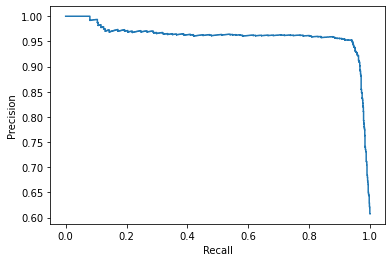

In [37]:
curve.plot()

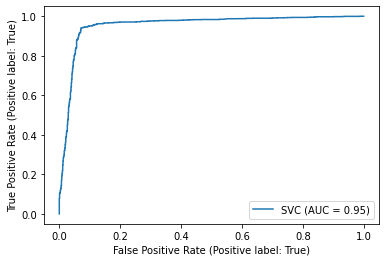

In [38]:
# Roc curve

roc = RocCurveDisplay.from_estimator(clf, x_test, y_test)
np.save('../data/roc_svm_tf.npy',roc)

array(<sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x000001D49544DEB0>,
      dtype=object)

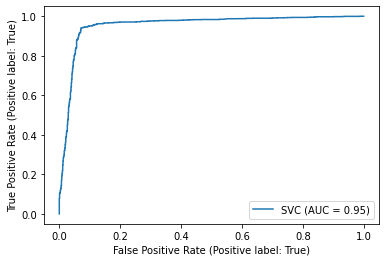

In [40]:
# prepared for further analyze, see conclusion
np.load('../data/roc_svm_tf.npy',allow_pickle=True)